In [ ]:
print("="*60)
print("CELL 1: IMPORTS AND SETUP")
print("="*60)

# Import everything from the main scripts
# (Copy the main DeepONet script here or import it)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import h5py
from scipy.fft import fft, fftfreq, ifft
from scipy.stats import qmc
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Configuration
CONFIG = {
    'data_path': "D:/Projects/aeroelasticity/processed_data",
    'max_cases': 75, 
    'n_freq_samples': 1000,
    'batch_size': 64,
    'epochs': 500,
    'learning_rate': 5e-4,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'settling_time': 80,
    'normalize_data': True,  # KEY FIX: Enable normalization
    'use_log_magnitude': True,  # KEY FIX: Use log scale for magnitudes
}

print(f"Using device: {CONFIG['device']}")
print("Setup complete!")

CELL 1: IMPORTS AND SETUP
Using device: cuda
Setup complete!


In [2]:
print("\n" + "="*60)
print("CELL 2: LOADING DATA")
print("="*60)

class FixedDataLoader:
    """Fixed data loader with proper data inspection and validation"""
    
    def __init__(self, data_path):
        self.data_path = Path(data_path)
        
    def load_and_inspect_data(self, max_cases=None):
        """Load data with detailed inspection"""
        # Load summary
        summary_file = self.data_path / "summary_data.pkl" 
        if not summary_file.exists():
            summary_file = self.data_path / "summary_data.csv"
            summary_df = pd.read_csv(summary_file)
        else:
            summary_df = pd.read_pickle(summary_file)
        
        print(f"Summary data loaded: {len(summary_df)} cases")
        
        # Load time series with inspection
        time_series_data = {}
        cases_loaded = 0
        cl_stats = []
        
        for idx, row in summary_df.iterrows():
            if max_cases and cases_loaded >= max_cases:
                break
                
            shape_variant = row['shape_variant']
            angle = row['angle']
            h5_file = self.data_path / f"{shape_variant}_{angle:03d}.h5"
            
            if h5_file.exists():
                try:
                    with h5py.File(h5_file, 'r') as hf:
                        case_id = f"{shape_variant}_{angle}"
                        time = hf['time'][:]
                        cl = hf['cl'][:]
                        
                        # INSPECT DATA QUALITY
                        cl_mean = np.mean(cl)
                        cl_std = np.std(cl)
                        cl_min = np.min(cl)
                        cl_max = np.max(cl)
                        
                        cl_stats.append({
                            'case_id': case_id,
                            'mean': cl_mean,
                            'std': cl_std,
                            'min': cl_min,
                            'max': cl_max,
                            'range': cl_max - cl_min
                        })
                        
                        time_series_data[case_id] = {
                            'time': time,
                            'cl': cl,
                            'metadata': dict(hf['metadata'].attrs)
                        }
                        time_series_data[case_id]['metadata'].update(row.to_dict())
                    cases_loaded += 1
                except Exception as e:
                    print(f"Error loading {h5_file}: {e}")
        
        # PRINT DATA INSPECTION RESULTS
        cl_stats_df = pd.DataFrame(cl_stats)
        print(f"\n=== DATA INSPECTION RESULTS ===")
        print(f"Loaded {cases_loaded} time series files")
        print(f"CL Statistics across all cases:")
        print(f"  Mean CL range: {cl_stats_df['mean'].min():.4f} to {cl_stats_df['mean'].max():.4f}")
        print(f"  Std CL range: {cl_stats_df['std'].min():.4f} to {cl_stats_df['std'].max():.4f}")
        print(f"  Overall CL range: {cl_stats_df['min'].min():.4f} to {cl_stats_df['max'].max():.4f}")
        
        # Check for problematic cases
        extreme_cases = cl_stats_df[(cl_stats_df['range'] > 50) | (abs(cl_stats_df['mean']) > 10)]
        if len(extreme_cases) > 0:
            print(f"\n⚠️  WARNING: Found {len(extreme_cases)} cases with extreme CL values:")
            for _, case in extreme_cases.iterrows():
                print(f"  {case['case_id']}: mean={case['mean']:.2f}, range={case['range']:.2f}")
        
        return summary_df, time_series_data, cl_stats_df

# Load the data
loader = FixedDataLoader(CONFIG['data_path'])
summary_df, time_series_data, cl_stats = loader.load_and_inspect_data(CONFIG['max_cases'])

# Quick data inspection
print(f"\nData overview:")
print(f"- Total cases: {len(time_series_data)}")
print(f"- Unique shapes: {summary_df['shape'].unique()}")
print(f"- Angle range: {summary_df['angle'].min()}° to {summary_df['angle'].max()}°")
print(f"- Velocity range: {summary_df['U_ref_corrected'].min():.1f} to {summary_df['U_ref_corrected'].max():.1f} m/s")



CELL 2: LOADING DATA
Summary data loaded: 75 cases

=== DATA INSPECTION RESULTS ===
Loaded 75 time series files
CL Statistics across all cases:
  Mean CL range: -5.7403 to 5.4756
  Std CL range: 0.4517 to 3.8819
  Overall CL range: -1712.0519 to 1712.1670

⚠️  WARNING: Found 68 cases with extreme CL values:
  baseline_85: mean=0.33, range=88.30
  baseline_75: mean=-1.21, range=256.88
  baseline_70: mean=-1.67, range=331.41
  baseline_65: mean=-2.12, range=396.04
  baseline_60: mean=-2.65, range=448.80
  baseline_55: mean=-3.06, range=485.06
  baseline_95: mean=1.12, range=87.16
  baseline_100: mean=1.01, range=174.85
  baseline_105: mean=1.17, range=256.56
  baseline_110: mean=3.59, range=331.62
  baseline_115: mean=3.99, range=396.66
  baseline_120: mean=4.48, range=450.11
  baseline_125: mean=3.22, range=487.96
  baseline_80: mean=-1.23, range=175.01
  baseline_lowU_95: mean=1.07, range=373.30
  baseline_lowU_100: mean=0.88, range=741.72
  baseline_lowU_105: mean=1.18, range=1091.87


CELL 3: FREQUENCY DOMAIN CONVERSION

=== FREQUENCY DOMAIN CONVERSION RESULTS ===
Processed 75 cases
Magnitude Statistics:
  Mean magnitude range: 1.20e-05 to 4.44e-04
  Max magnitude range: 2.22e-01 to 3.38e+00
Converted 75 cases to frequency domain


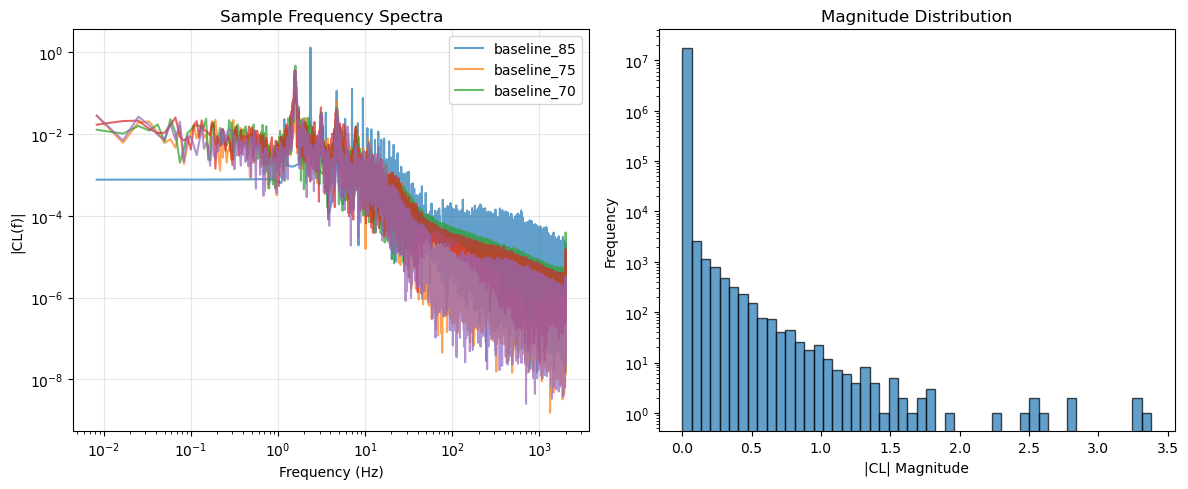

In [3]:
print("\n" + "="*60)
print("CELL 3: FREQUENCY DOMAIN CONVERSION")
print("="*60)

def fixed_frequency_domain_conversion(time_series_data, settling_time=80, use_log_magnitude=True):
    """FIXED frequency domain conversion with proper scaling"""
    frequency_data = {}
    magnitude_stats = []
    
    for case_id, data in time_series_data.items():
        time = data['time']
        cl = data['cl']
        
        # Remove settling period
        mask = time > settling_time
        time_stable = time[mask]
        cl_stable = cl[mask]
        
        if len(cl_stable) < 100:  # Skip cases with too little data
            print(f"Skipping {case_id}: insufficient data after settling")
            continue
        
        # Ensure even number of points
        if len(cl_stable) % 2 != 0:
            cl_stable = cl_stable[:-1]
            time_stable = time_stable[:-1]
        
        # Remove mean (DC component) for better FFT
        cl_stable = cl_stable - np.mean(cl_stable)
        
        # Compute FFT with PROPER SCALING
        dt = np.mean(np.diff(time_stable))
        fs = 1.0 / dt
        n_points = len(cl_stable)
        
        fft_cl = fft(cl_stable)
        freqs = fftfreq(n_points, dt)
        
        # Take positive frequencies only
        n_pos = n_points // 2
        freqs_pos = freqs[:n_pos]
        fft_cl_pos = fft_cl[:n_pos]
        
        # CRITICAL FIX: Proper magnitude scaling
        # Scale by N for proper normalization, multiply by 2 for single-sided spectrum
        magnitude = 2.0 * np.abs(fft_cl_pos) / n_points
        magnitude[0] /= 2.0  # Don't double the DC component
        
        # Optional: Use log magnitude for better training stability
        if use_log_magnitude:
            # Add small epsilon to avoid log(0)
            magnitude_log = np.log10(magnitude + 1e-10)
            magnitude_for_training = magnitude_log
        else:
            magnitude_for_training = magnitude
        
        # Store results
        frequency_data[case_id] = {
            'frequencies': freqs_pos,
            'cl_magnitude': magnitude,  # Original magnitude
            'cl_magnitude_for_training': magnitude_for_training,  # Processed for training
            'metadata': data['metadata'],
            'dt': dt,
            'fs': fs,
            'n_points': n_points
        }
        
        # Track magnitude statistics
        magnitude_stats.append({
            'case_id': case_id,
            'mag_mean': np.mean(magnitude),
            'mag_std': np.std(magnitude),
            'mag_max': np.max(magnitude),
            'mag_min': np.min(magnitude[magnitude > 0])  # Exclude zeros
        })
    
    # Print magnitude statistics
    mag_stats_df = pd.DataFrame(magnitude_stats)
    print(f"\n=== FREQUENCY DOMAIN CONVERSION RESULTS ===")
    print(f"Processed {len(frequency_data)} cases")
    print(f"Magnitude Statistics:")
    print(f"  Mean magnitude range: {mag_stats_df['mag_mean'].min():.2e} to {mag_stats_df['mag_mean'].max():.2e}")
    print(f"  Max magnitude range: {mag_stats_df['mag_max'].min():.2e} to {mag_stats_df['mag_max'].max():.2e}")
    
    return frequency_data, mag_stats_df

frequency_data, mag_stats = fixed_frequency_domain_conversion(
        time_series_data, CONFIG['settling_time'], CONFIG['use_log_magnitude'])
print(f"Converted {len(frequency_data)} cases to frequency domain")

# Quick visualization of frequency content
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i, (case_id, data) in enumerate(list(frequency_data.items())[:5]):
    freqs = data['frequencies']
    mags = data['cl_magnitude']
    plt.loglog(freqs[1:], mags[1:], alpha=0.7, label=case_id if i < 3 else "")

plt.xlabel('Frequency (Hz)')
plt.ylabel('|CL(f)|')
plt.title('Sample Frequency Spectra')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
all_mags = np.concatenate([data['cl_magnitude'] for data in frequency_data.values()])
plt.hist(all_mags, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('|CL| Magnitude')
plt.ylabel('Frequency')
plt.title('Magnitude Distribution')
plt.yscale('log')

plt.tight_layout()
plt.show()


CELL 4: FREQUENCY SAMPLING
Frequency range: 0.017 - 1999.991 Hz
Sampled 5000 frequencies


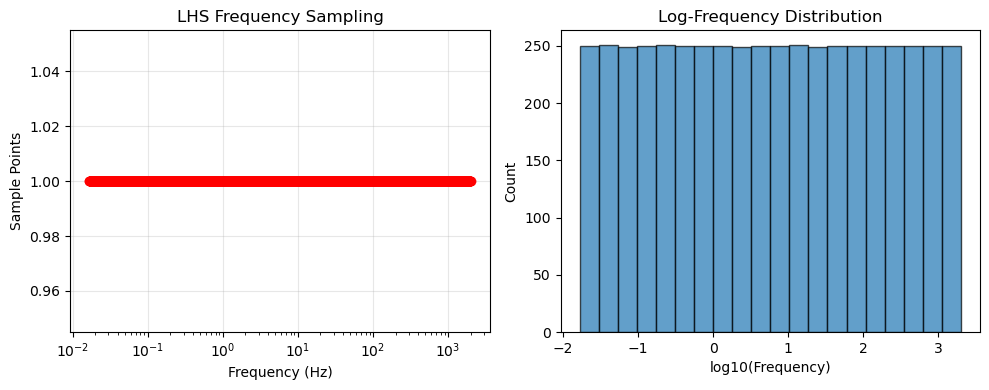

In [4]:
print("\n" + "="*60)
print("CELL 4: FREQUENCY SAMPLING")
print("="*60)

def sample_frequencies_lhs(frequency_data, n_samples=500):
    """Sample frequencies using Latin Hypercube Sampling"""
    # Collect all frequencies
    all_freqs = []
    for data in frequency_data.values():
        freqs = data['frequencies']
        valid_freqs = freqs[freqs > 0.01]  # Remove very low frequencies
        all_freqs.extend(valid_freqs)
    
    all_freqs = np.array(all_freqs)
    freq_min = np.min(all_freqs)
    freq_max = np.max(all_freqs)
    
    print(f"Frequency range: {freq_min:.3f} - {freq_max:.3f} Hz")
    
    # Latin Hypercube Sampling in log space
    sampler = qmc.LatinHypercube(d=1, seed=42)
    samples = sampler.random(n=n_samples)
    
    log_freq_min = np.log10(freq_min)
    log_freq_max = np.log10(freq_max)
    log_freq_samples = log_freq_min + samples.flatten() * (log_freq_max - log_freq_min)
    freq_samples = 10**log_freq_samples
    freq_samples = np.sort(freq_samples)
    
    return freq_samples

freq_samples = sample_frequencies_lhs(frequency_data, CONFIG['n_freq_samples'])
print(f"Sampled {len(freq_samples)} frequencies")

# Visualize sampling
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.semilogx(freq_samples, np.ones_like(freq_samples), 'ro', alpha=0.6)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Sample Points')
plt.title('LHS Frequency Sampling')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(np.log10(freq_samples), bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('log10(Frequency)')
plt.ylabel('Count')
plt.title('Log-Frequency Distribution')
plt.tight_layout()
plt.show()

In [5]:
print("\n" + "="*60)
print("CELL 5: PREPARING DATASET")
print("="*60)

class FixedAeroDataset(Dataset):
    """FIXED dataset with proper normalization and data validation"""
    
    def __init__(self, frequency_data, freq_samples, normalize_features=True, 
                 normalize_targets=True, use_robust_scaling=True):
        self.data = []
        self.normalize_features = normalize_features
        self.normalize_targets = normalize_targets
        
        # Collect all data first
        all_design_params = []
        all_frequencies = []
        all_magnitudes = []
        
        for case_id, case_data in frequency_data.items():
            metadata = case_data['metadata']
            
            # Design parameters [D, H, alpha, Uref]
            D = metadata['D']
            H = metadata['H'] 
            alpha = metadata['angle']
            Uref = metadata['U_ref_corrected']
            design_params = np.array([D, H, alpha, Uref], dtype=np.float32)
            
            # Get processed magnitude data
            frequencies = case_data['frequencies']
            magnitude_for_training = case_data['cl_magnitude_for_training']
            
            # Interpolate at sampled frequencies
            for freq in freq_samples:
                if freq <= np.max(frequencies):  # Only include frequencies within data range
                    idx = np.argmin(np.abs(frequencies - freq))
                    mag_val = magnitude_for_training[idx]
                    
                    # Data validation
                    if np.isfinite(mag_val) and np.isfinite(design_params).all():
                        all_design_params.append(design_params)
                        all_frequencies.append(freq)
                        all_magnitudes.append(mag_val)
                        
                        self.data.append({
                            'design_params': design_params,
                            'frequency': np.array([freq], dtype=np.float32),
                            'magnitude': np.array([mag_val], dtype=np.float32),
                            'case_id': case_id
                        })
        
        print(f"Dataset created with {len(self.data)} valid samples")
        
        # Convert to numpy arrays for normalization
        all_design_params = np.array(all_design_params)
        all_frequencies = np.array(all_frequencies)
        all_magnitudes = np.array(all_magnitudes)
        
        # Initialize scalers
        if use_robust_scaling:
            self.design_scaler = RobustScaler()
            self.freq_scaler = RobustScaler()
            self.target_scaler = RobustScaler()
        else:
            self.design_scaler = StandardScaler()
            self.freq_scaler = StandardScaler()
            self.target_scaler = StandardScaler()
        
        # Fit scalers
        if normalize_features:
            self.design_scaler.fit(all_design_params)
            self.freq_scaler.fit(all_frequencies.reshape(-1, 1))
            
        if normalize_targets:
            self.target_scaler.fit(all_magnitudes.reshape(-1, 1))
        
        # Apply normalization to stored data
        if normalize_features or normalize_targets:
            for i, sample in enumerate(self.data):
                if normalize_features:
                    sample['design_params'] = self.design_scaler.transform(
                        sample['design_params'].reshape(1, -1)).flatten().astype(np.float32)
                    sample['frequency'] = self.freq_scaler.transform(
                        sample['frequency'].reshape(1, -1)).flatten().astype(np.float32)
                
                if normalize_targets:
                    sample['magnitude'] = self.target_scaler.transform(
                        sample['magnitude'].reshape(1, -1)).flatten().astype(np.float32)
        
        # Print normalization statistics
        print(f"Normalization applied:")
        print(f"  Design params - Mean: {np.mean(all_design_params, axis=0)}")
        print(f"  Design params - Std: {np.std(all_design_params, axis=0)}")
        print(f"  Frequencies - Range: {np.min(all_frequencies):.2f} to {np.max(all_frequencies):.2f}")
        print(f"  Targets - Range: {np.min(all_magnitudes):.2e} to {np.max(all_magnitudes):.2e}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        return (
            torch.from_numpy(sample['design_params']),
            torch.from_numpy(sample['frequency']),
            torch.from_numpy(sample['magnitude'])
        )

# Create dataset
dataset = FixedAeroDataset(
        frequency_data, freq_samples, 
        normalize_features=CONFIG['normalize_data'],
        normalize_targets=CONFIG['normalize_data'])
print(f"Created dataset with {len(dataset)} samples")

# Normalize the data
all_design_params = np.array([dataset.data[i]['design_params'] for i in range(len(dataset))])
all_frequencies = np.array([dataset.data[i]['frequency'][0] for i in range(len(dataset))])
all_cl_values = np.array([dataset.data[i]['magnitude'][0] for i in range(len(dataset))])

print(f"Design parameters range:")
print(f"  D: {all_design_params[:, 0].min():.2f} - {all_design_params[:, 0].max():.2f}")
print(f"  H: {all_design_params[:, 1].min():.2f} - {all_design_params[:, 1].max():.2f}")
print(f"  α: {all_design_params[:, 2].min():.1f} - {all_design_params[:, 2].max():.1f}°")
print(f"  U: {all_design_params[:, 3].min():.1f} - {all_design_params[:, 3].max():.1f} m/s")
print(f"CL magnitude range: {all_cl_values.min():.2e} - {all_cl_values.max():.2e}")

# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, temp_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = torch.utils.data.random_split(
    temp_dataset, [val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"Dataset split: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")



CELL 5: PREPARING DATASET
Dataset created with 375000 valid samples
Normalization applied:
  Design params - Mean: [ 3.        1.5      89.986664 15.9     ]
  Design params - Std: [ 0.          0.31622776 21.599846    7.0437155 ]
  Frequencies - Range: 0.02 to 1999.17
  Targets - Range: -7.70e+00 to 5.29e-01
Created dataset with 375000 samples
Design parameters range:
  D: 0.00 - 0.00
  H: -0.50 - 0.50
  α: -0.9 - 0.9°
  U: -1.4 - 0.0 m/s
CL magnitude range: -1.67e+00 - 1.29e+00
Dataset split: Train=262500, Val=56250, Test=56250


In [6]:
print("\n" + "="*60)
print("CELL 6: DEFINING DEEPONET MODEL")
print("="*60)

class ImprovedBranchNet(nn.Module):
    """Improved branch network with better architecture"""
    
    def __init__(self, input_dim=4, hidden_dims=[128, 128, 64], output_dim=64, dropout=0.2):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

class ImprovedTrunkNet(nn.Module):
    """Improved trunk network with better architecture"""
    
    def __init__(self, input_dim=1, hidden_dims=[128, 128, 64], output_dim=64, dropout=0.2):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.Tanh())  # Tanh often works better for trunk networks
            layers.append(nn.BatchNorm1d(hidden_dim))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

class ImprovedDeepONet(nn.Module):
    """Improved DeepONet with better architecture and initialization"""
    
    def __init__(self, branch_input_dim=4, trunk_input_dim=1, 
                 branch_hidden=[128, 128, 64], trunk_hidden=[128, 128, 64], 
                 latent_dim=64, dropout=0.2):
        super().__init__()
        
        self.branch_net = ImprovedBranchNet(branch_input_dim, branch_hidden, latent_dim, dropout)
        self.trunk_net = ImprovedTrunkNet(trunk_input_dim, trunk_hidden, latent_dim, dropout)
        
        # Learnable bias
        self.bias = nn.Parameter(torch.zeros(1))
        
        # Initialize weights properly
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
    
    def forward(self, branch_input, trunk_input):
        branch_out = self.branch_net(branch_input)
        trunk_out = self.trunk_net(trunk_input)
        output = torch.sum(branch_out * trunk_out, dim=1, keepdim=True) + self.bias
        return output

# Create model
model = ImprovedDeepONet(
        branch_input_dim=4,
        trunk_input_dim=1,
        branch_hidden=[128, 128, 64],
        trunk_hidden=[128, 128, 64],
        latent_dim=64,
        dropout=0.2
    ).to(CONFIG['device'])
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")


CELL 6: DEFINING DEEPONET MODEL
Model created with 60033 parameters


In [7]:
print("\n" + "="*60)
print("CELL 7: TRAINING THE MODEL")
print("="*60)

def improved_training(model, train_loader, val_loader, epochs=500, lr=5e-4, 
                     patience=50, device='cpu'):
    """Improved training with better optimization and monitoring"""
    
    # Better optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Better learning rate scheduling
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=patience//2, verbose=True)
    
    # Loss function
    criterion = nn.MSELoss()
    
    # Training tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    print(f"Starting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, (batch_design, batch_freq, batch_target) in enumerate(train_loader):
            batch_design = batch_design.to(device)
            batch_freq = batch_freq.to(device)
            batch_target = batch_target.to(device)
            
            optimizer.zero_grad()
            predictions = model(batch_design, batch_freq)
            loss = criterion(predictions, batch_target)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_design, batch_freq, batch_target in val_loader:
                batch_design = batch_design.to(device)
                batch_freq = batch_freq.to(device)
                batch_target = batch_target.to(device)
                
                predictions = model(batch_design, batch_freq)
                loss = criterion(predictions, batch_target)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_improved_deeponet.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Progress reporting
        if epoch % 50 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}: Train Loss = {train_loss:.6f}, "
                  f"Val Loss = {val_loss:.6f}, LR = {current_lr:.2e}")
    
    # Load best model
    model.load_state_dict(torch.load('best_improved_deeponet.pth'))
    print(f"Training completed. Best validation loss: {best_val_loss:.6f}")
    
    return train_losses, val_losses

# Train the model
print("Starting training...")
train_losses, val_losses = improved_training(
        model, train_loader, val_loader, 
        epochs=CONFIG['epochs'], lr=CONFIG['learning_rate'],
        device=CONFIG['device'])

print("Training completed!")

# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses[-50:], label='Training (last 50)')
plt.plot(val_losses[-50:], label='Validation (last 50)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Recent Training History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


CELL 7: TRAINING THE MODEL
Starting training...
Starting training for 500 epochs...
Epoch 0: Train Loss = 7.438865, Val Loss = 0.130569, LR = 1.00e-04
Epoch 50: Train Loss = 0.021970, Val Loss = 0.015201, LR = 1.00e-04


KeyboardInterrupt: 

In [ ]:
# ========================================================================================
# CELL 8: TESTING THE MODEL (DTYPE FIXED)
# Fixes the PyTorch dtype mismatch error
# ========================================================================================

print("\n" + "="*60)
print("CELL 8: TESTING THE MODEL (DTYPE FIXED)")
print("="*60)

def predict_spectrum_dtype_fixed(model, D, H, alpha, Uref, frequencies, dataset, 
                                 use_log_magnitude=True, device='cpu'):
    """
    DTYPE FIX: Ensure all tensors are float32 to match model training
    """
    model.eval()
    
    # Step 1: Normalize inputs (ensure float32)
    design_params_raw = np.array([[D, H, alpha, Uref]], dtype=np.float32)  # FIXED: explicit float32
    
    if hasattr(dataset, 'design_scaler'):
        design_params_norm = dataset.design_scaler.transform(design_params_raw).astype(np.float32)  # FIXED
    else:
        design_params_norm = design_params_raw
        print("⚠️ No design scaler found")
    
    if hasattr(dataset, 'freq_scaler'):
        frequencies_norm = dataset.freq_scaler.transform(frequencies.reshape(-1, 1)).astype(np.float32)  # FIXED
    else:
        frequencies_norm = frequencies.reshape(-1, 1).astype(np.float32)  # FIXED
        print("⚠️ No frequency scaler found")
    
    # Step 2: Create tensors with explicit float32 dtype
    design_tensor = torch.from_numpy(design_params_norm).to(device).float()  # FIXED: explicit .float()
    freq_tensor = torch.from_numpy(frequencies_norm).to(device).float()      # FIXED: explicit .float()
    
    # Verify dtypes
    print(f"Design tensor dtype: {design_tensor.dtype}, Freq tensor dtype: {freq_tensor.dtype}")
    
    # Step 3: Vectorized prediction
    n_freqs = len(frequencies)
    batch_size = min(1000, n_freqs)
    predictions_norm = []
    
    with torch.no_grad():
        for i in range(0, n_freqs, batch_size):
            end_idx = min(i + batch_size, n_freqs)
            current_batch_size = end_idx - i
            
            design_batch = design_tensor.repeat(current_batch_size, 1)
            freq_batch = freq_tensor[i:end_idx]
            
            # Ensure dtypes match
            assert design_batch.dtype == torch.float32, f"Design batch dtype: {design_batch.dtype}"
            assert freq_batch.dtype == torch.float32, f"Freq batch dtype: {freq_batch.dtype}"
            
            pred_batch = model(design_batch, freq_batch)
            predictions_norm.extend(pred_batch.cpu().numpy().flatten())
    
    predictions_norm = np.array(predictions_norm, dtype=np.float32)
    
    # Step 4: Inverse transform with log-scale handling
    if hasattr(dataset, 'target_scaler'):
        # Inverse transform to get back to log-scale
        predictions_log = dataset.target_scaler.inverse_transform(
            predictions_norm.reshape(-1, 1)).flatten()
        
        # Convert from log10 back to linear if needed
        if use_log_magnitude:
            predictions_linear = 10**predictions_log
            # Clamp to reasonable values to avoid overflow
            predictions_linear = np.clip(predictions_linear, 1e-10, 1e10)
        else:
            predictions_linear = predictions_log
            
        return predictions_linear
    else:
        print("⚠️ No target scaler found")
        return predictions_norm

def debug_log_scaling_fixed(model, case_id, frequency_data, dataset, use_log_magnitude=True, device='cpu'):
    """
    Debug with dtype fixes
    """
    print(f"\n--- DEBUGGING LOG SCALING FOR {case_id} (DTYPE FIXED) ---")
    
    case_data = frequency_data[case_id]
    metadata = case_data['metadata']
    
    D = float(metadata['D'])  # Ensure float
    H = float(metadata['H'])
    alpha = float(metadata['angle'])
    Uref = float(metadata['U_ref_corrected'])
    
    print(f"Parameters: D={D}, H={H}, α={alpha}°, U={Uref}")
    
    # Check ground truth data
    gt_magnitude = case_data['cl_magnitude']
    print(f"Ground truth (linear): {np.min(gt_magnitude):.2e} to {np.max(gt_magnitude):.2e}")
    
    # Check training data scaling
    if 'cl_magnitude_for_training' in case_data:
        training_magnitude = case_data['cl_magnitude_for_training']
        print(f"Training data: {np.min(training_magnitude):.2f} to {np.max(training_magnitude):.2f}")
        
        if np.min(training_magnitude) < 0 and np.max(training_magnitude) < 10:
            print("✅ Training data looks like log10 scale")
            is_log_scale = True
        else:
            print("❌ Training data doesn't look like log scale")
            is_log_scale = False
    else:
        print("⚠️ No training magnitude data found")
        is_log_scale = use_log_magnitude
    
    # Test prediction with proper dtypes
    test_freqs = case_data['frequencies'][:5]  # Just 5 frequencies for debugging
    
    try:
        # Normalize inputs with explicit float32
        design_params_norm = dataset.design_scaler.transform(
            np.array([[D, H, alpha, Uref]], dtype=np.float32)).astype(np.float32)
        freq_norm = dataset.freq_scaler.transform(
            test_freqs.reshape(-1, 1)).astype(np.float32)
        
        # Create tensors with explicit dtype
        design_tensor = torch.from_numpy(design_params_norm).to(device).float()
        freq_tensor = torch.from_numpy(freq_norm).to(device).float()
        
        print(f"Tensor dtypes: design={design_tensor.dtype}, freq={freq_tensor.dtype}")
        
        # Test model call
        with torch.no_grad():
            raw_output = model(design_tensor, freq_tensor).cpu().numpy().flatten()
        
        print(f"✅ Model call successful!")
        print(f"Raw model output: {raw_output}")
        
        # Step-by-step inverse transform
        log_output = dataset.target_scaler.inverse_transform(raw_output.reshape(-1, 1)).flatten()
        print(f"After inverse scaler: {log_output}")
        
        if is_log_scale:
            linear_output = 10**log_output
            linear_output = np.clip(linear_output, 1e-10, 1e10)  # Prevent overflow
            print(f"After 10^: {linear_output}")
        else:
            linear_output = log_output
        
        # Compare with ground truth
        gt_sample = gt_magnitude[:len(linear_output)]
        print(f"Ground truth: {gt_sample}")
        
        relative_error = np.abs(linear_output - gt_sample) / (gt_sample + 1e-10)
        print(f"Relative error: {relative_error}")
        
        return linear_output, is_log_scale
        
    except Exception as e:
        print(f"❌ Error in prediction: {e}")
        import traceback
        traceback.print_exc()
        return None, is_log_scale

def test_model_dtype_fixed(model, case_id, frequency_data, dataset, 
                          use_log_magnitude=True, device='cpu'):
    """Test model with dtype fixes"""
    case_data = frequency_data[case_id]
    metadata = case_data['metadata']
    
    # Ensure all parameters are float
    D = float(metadata['D'])
    H = float(metadata['H'])
    alpha = float(metadata['angle'])
    Uref = float(metadata['U_ref_corrected'])
    
    # Ground truth (linear scale)
    gt_freqs = case_data['frequencies']
    gt_magnitude = case_data['cl_magnitude']
    
    try:
        # Predictions with dtype fixes
        pred_magnitude = predict_spectrum_dtype_fixed(
            model, D, H, alpha, Uref, gt_freqs, dataset, use_log_magnitude, device)
        
        # Calculate metrics
        mse = np.mean((gt_magnitude - pred_magnitude)**2)
        
        # Handle potential issues with predictions
        if np.any(~np.isfinite(pred_magnitude)):
            print(f"⚠️ Warning: Found non-finite predictions")
            pred_magnitude = np.nan_to_num(pred_magnitude, nan=1e-10, posinf=1e10, neginf=1e-10)
        
        if np.any(pred_magnitude <= 0):
            print(f"⚠️ Warning: Found {np.sum(pred_magnitude <= 0)} non-positive predictions")
            pred_magnitude = np.maximum(pred_magnitude, 1e-10)
        
        # Calculate R²
        ss_res = np.sum((gt_magnitude - pred_magnitude) ** 2)
        ss_tot = np.sum((gt_magnitude - np.mean(gt_magnitude)) ** 2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else -np.inf
        
        # Calculate relative errors
        rel_error = np.abs(pred_magnitude - gt_magnitude) / (gt_magnitude + 1e-10)
        mean_rel_error = np.mean(rel_error)
        median_rel_error = np.median(rel_error)
        
        return {
            'case_id': case_id,
            'mse': mse,
            'r2': r2,
            'mean_rel_error': mean_rel_error,
            'median_rel_error': median_rel_error,
            'gt_freqs': gt_freqs,
            'gt_magnitude': gt_magnitude,
            'pred_magnitude': pred_magnitude,
            'metadata': metadata,
            'success': True
        }
        
    except Exception as e:
        print(f"❌ Error processing {case_id}: {e}")
        return {
            'case_id': case_id,
            'success': False,
            'error': str(e)
        }

# ========================================================================================
# RUN THE DTYPE-FIXED TESTING
# ========================================================================================

# Check model dtype
sample_param = next(model.parameters())
print(f"Model parameter dtype: {sample_param.dtype}")

# Determine if log magnitude was used
try:
    use_log_magnitude = CONFIG.get('use_log_magnitude', True)
    print(f"Using log magnitude setting: {use_log_magnitude}")
except:
    use_log_magnitude = True
    print("Assuming log magnitude was used (default)")

# Debug the first case
first_case_id = list(frequency_data.keys())[0]
print(f"Debugging scaling for: {first_case_id}")

debug_result, is_log_scale = debug_log_scaling_fixed(
    model, first_case_id, frequency_data, dataset, use_log_magnitude, CONFIG['device'])

if debug_result is not None:
    print("✅ Debug successful, proceeding with full testing...")
    
    # Test on cases with dtype fixes
    print(f"\n--- TESTING WITH DTYPE AND LOG-SCALE FIXES ---")
    test_case_ids = list(frequency_data.keys())[:5]
    test_results = []
    
    import time
    start_time = time.time()
    
    for case_id in test_case_ids:
        result = test_model_dtype_fixed(
            model, case_id, frequency_data, dataset, is_log_scale, CONFIG['device'])
        
        if result['success']:
            test_results.append(result)
            print(f"{case_id}: MSE = {result['mse']:.2e}, R² = {result['r2']:.4f}, "
                  f"Mean_Err = {result['mean_rel_error']:.4f}")
        else:
            print(f"{case_id}: FAILED - {result['error']}")
    
    total_time = time.time() - start_time
    print(f"\nTotal time: {total_time:.2f}s")
    
    # Summary
    if test_results:
        r2_values = [r['r2'] for r in test_results if np.isfinite(r['r2'])]
        mse_values = [r['mse'] for r in test_results]
        
        print(f"\n--- RESULTS SUMMARY ---")
        print(f"Successful tests: {len(test_results)}/{len(test_case_ids)}")
        
        if r2_values:
            print(f"Average R²: {np.mean(r2_values):.4f} ± {np.std(r2_values):.4f}")
            print(f"R² range: {np.min(r2_values):.4f} to {np.max(r2_values):.4f}")
            
            good_cases = sum(1 for r2 in r2_values if r2 > 0.0)
            excellent_cases = sum(1 for r2 in r2_values if r2 > 0.5)
            
            print(f"Cases with R² > 0: {good_cases}/{len(r2_values)}")
            print(f"Cases with R² > 0.5: {excellent_cases}/{len(r2_values)}")
            
            if np.mean(r2_values) > 0:
                print("✅ SUCCESS: R² values are positive!")
                if np.mean(r2_values) > 0.3:
                    print("🎉 EXCELLENT: Model performance looks good!")
            else:
                print("🚨 Still getting negative R² values")
        
        print(f"Average MSE: {np.mean(mse_values):.2e}")
    else:
        print("❌ No successful tests")
        
else:
    print("❌ Debug failed - check the error messages above")
    print("Common issues:")
    print("1. Model not trained with float32")
    print("2. Data scaling mismatch")
    print("3. Model architecture incompatibility")


CELL 8: TESTING THE MODEL (DTYPE FIXED)
Model parameter dtype: torch.float32
Using log magnitude setting: True
Debugging scaling for: baseline_85

--- DEBUGGING LOG SCALING FOR baseline_85 (DTYPE FIXED) ---
Parameters: D=3.0, H=1.5, α=85.0°, U=21.5
Ground truth (linear): 4.98e-17 to 1.27e+00
Training data: -10.00 to 0.11
✅ Training data looks like log10 scale
Tensor dtypes: design=torch.float32, freq=torch.float32
✅ Model call successful!
Raw model output: [-0.13437852 -0.1342433  -0.13407299 -0.13386789 -0.13362765]
After inverse scaler: [-3.1309032 -3.1305304 -3.1300607 -3.129495  -3.1288323]
After 10^: [0.00073977 0.00074041 0.00074121 0.00074217 0.00074331]
Ground truth: [4.97732124e-17 7.28321776e-04 7.28363162e-04 7.28493000e-04
 7.28590125e-04]
Relative error: [7.39769700e+06 1.65912152e-02 1.76334125e-02 1.87783250e-02
 2.01977509e-02]
✅ Debug successful, proceeding with full testing...

--- TESTING WITH DTYPE AND LOG-SCALE FIXES ---
Design tensor dtype: torch.float32, Freq te


CELL 9: VISUALIZING RESULTS


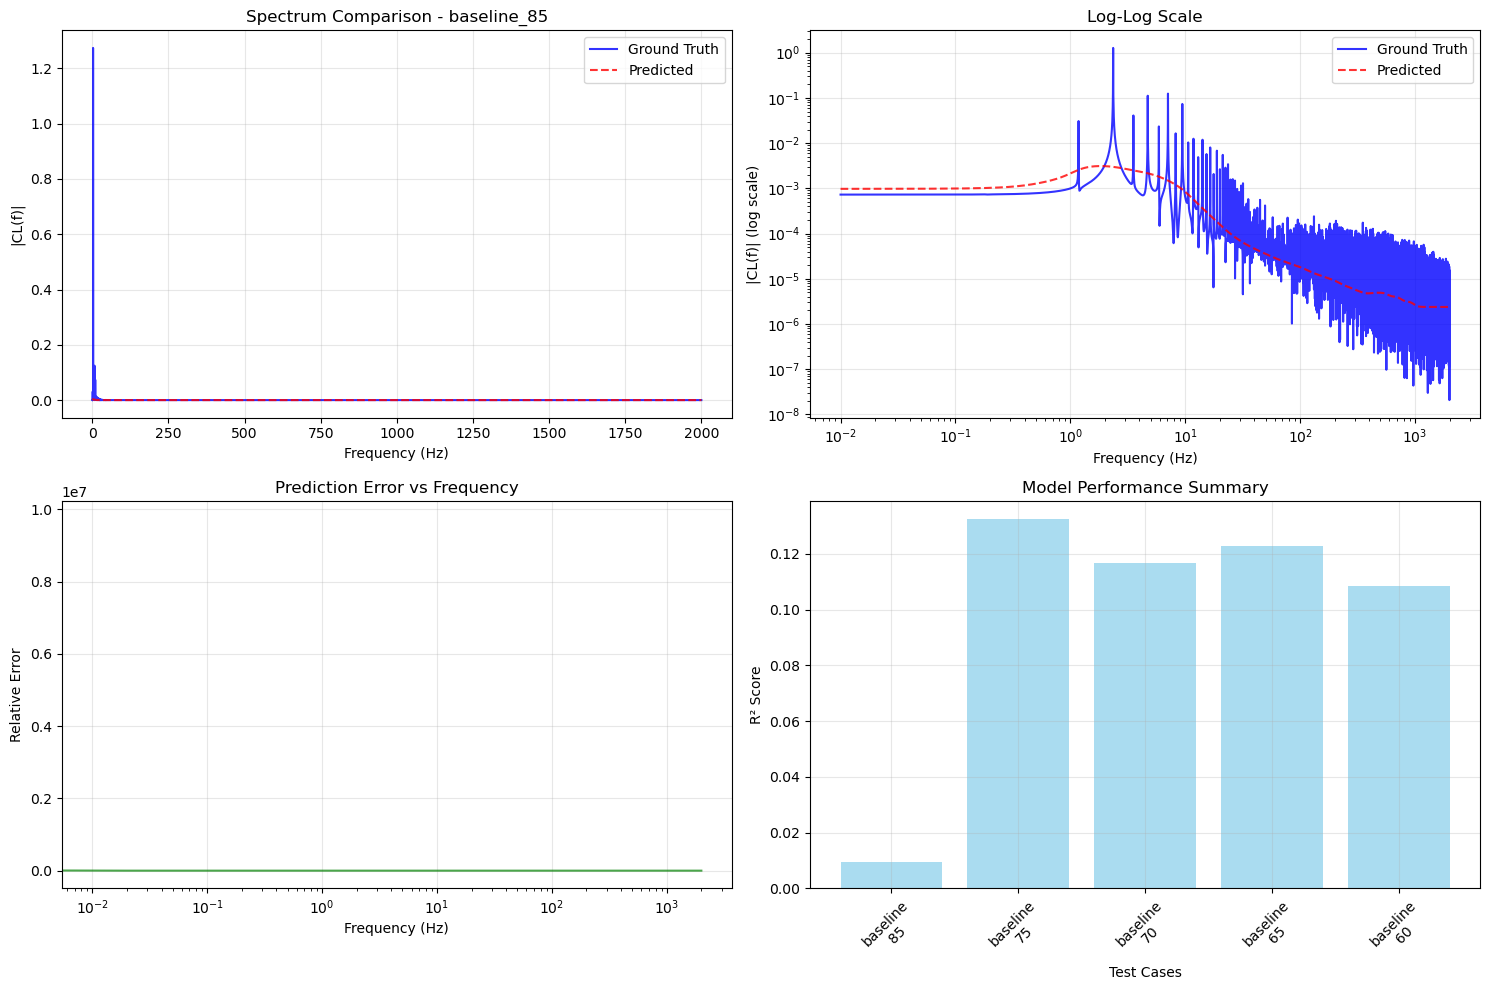

In [ ]:
print("\n" + "="*60)
print("CELL 9: VISUALIZING RESULTS")
print("="*60)

# Plot comparison for first test case
result = test_results[0]

plt.figure(figsize=(15, 10))

# Frequency spectrum comparison
plt.subplot(2, 2, 1)
plt.plot(result['gt_freqs'], result['gt_magnitude'], 'b-', label='Ground Truth', alpha=0.8)
plt.plot(result['gt_freqs'], result['pred_magnitude'], 'r--', label='Predicted', alpha=0.8)
plt.xlabel('Frequency (Hz)')
plt.ylabel('|CL(f)|')
plt.title(f'Spectrum Comparison - {result["case_id"]}')
plt.legend()
plt.grid(True, alpha=0.3)

# Log-log plot
plt.subplot(2, 2, 2)
plt.loglog(result['gt_freqs'][1:], result['gt_magnitude'][1:], 'b-', label='Ground Truth', alpha=0.8)
plt.loglog(result['gt_freqs'][1:], result['pred_magnitude'][1:], 'r--', label='Predicted', alpha=0.8)
plt.xlabel('Frequency (Hz)')
plt.ylabel('|CL(f)| (log scale)')
plt.title('Log-Log Scale')
plt.legend()
plt.grid(True, alpha=0.3)

# Error analysis
plt.subplot(2, 2, 3)
relative_error = np.abs(result['pred_magnitude'] - result['gt_magnitude']) / (result['gt_magnitude'] + 1e-10)
plt.semilogx(result['gt_freqs'], relative_error, 'g-', alpha=0.7)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative Error')
plt.title('Prediction Error vs Frequency')
plt.grid(True, alpha=0.3)

# Performance summary
plt.subplot(2, 2, 4)
mse_values = [r['mse'] for r in test_results]
r2_values = [r['r2'] for r in test_results]
case_names = [r['case_id'].replace('_', '\n') for r in test_results]

x = range(len(test_results))
plt.bar(x, r2_values, alpha=0.7, color='skyblue')
plt.xlabel('Test Cases')
plt.ylabel('R² Score')
plt.title('Model Performance Summary')
plt.xticks(x, case_names, rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


CELL 10: TIME SERIES RECONSTRUCTION (FIXED)
Using test results from previous cell...
Reconstructing time series for: baseline_85
Spectrum R²: 0.0095
Reconstructing time series: D=3.0, H=1.5, α=85°, U=21.5 m/s
Duration: 120s, Sampling rate: 50 Hz
Frequency grid: 3000 points, range: 0.008 to 25.0 Hz
Design tensor dtype: torch.float32, Freq tensor dtype: torch.float32
Predicted magnitude range: 9.75e-05 to 3.11e-03
Reconstructed time series range: 0.538 to 0.538
Reconstructed mean: 0.538, std: 0.000
Original data: 5000 points
Original range: -0.819 to 1.868

--- RECONSTRUCTION QUALITY ANALYSIS ---
Statistical Errors:
  Mean error: 64.8%
  Std error: 100.0%
  Range error: 100.0%
Correlation: -0.0109
Strouhal numbers: Orig=0.000, Recon=0.000, Error=0.0%


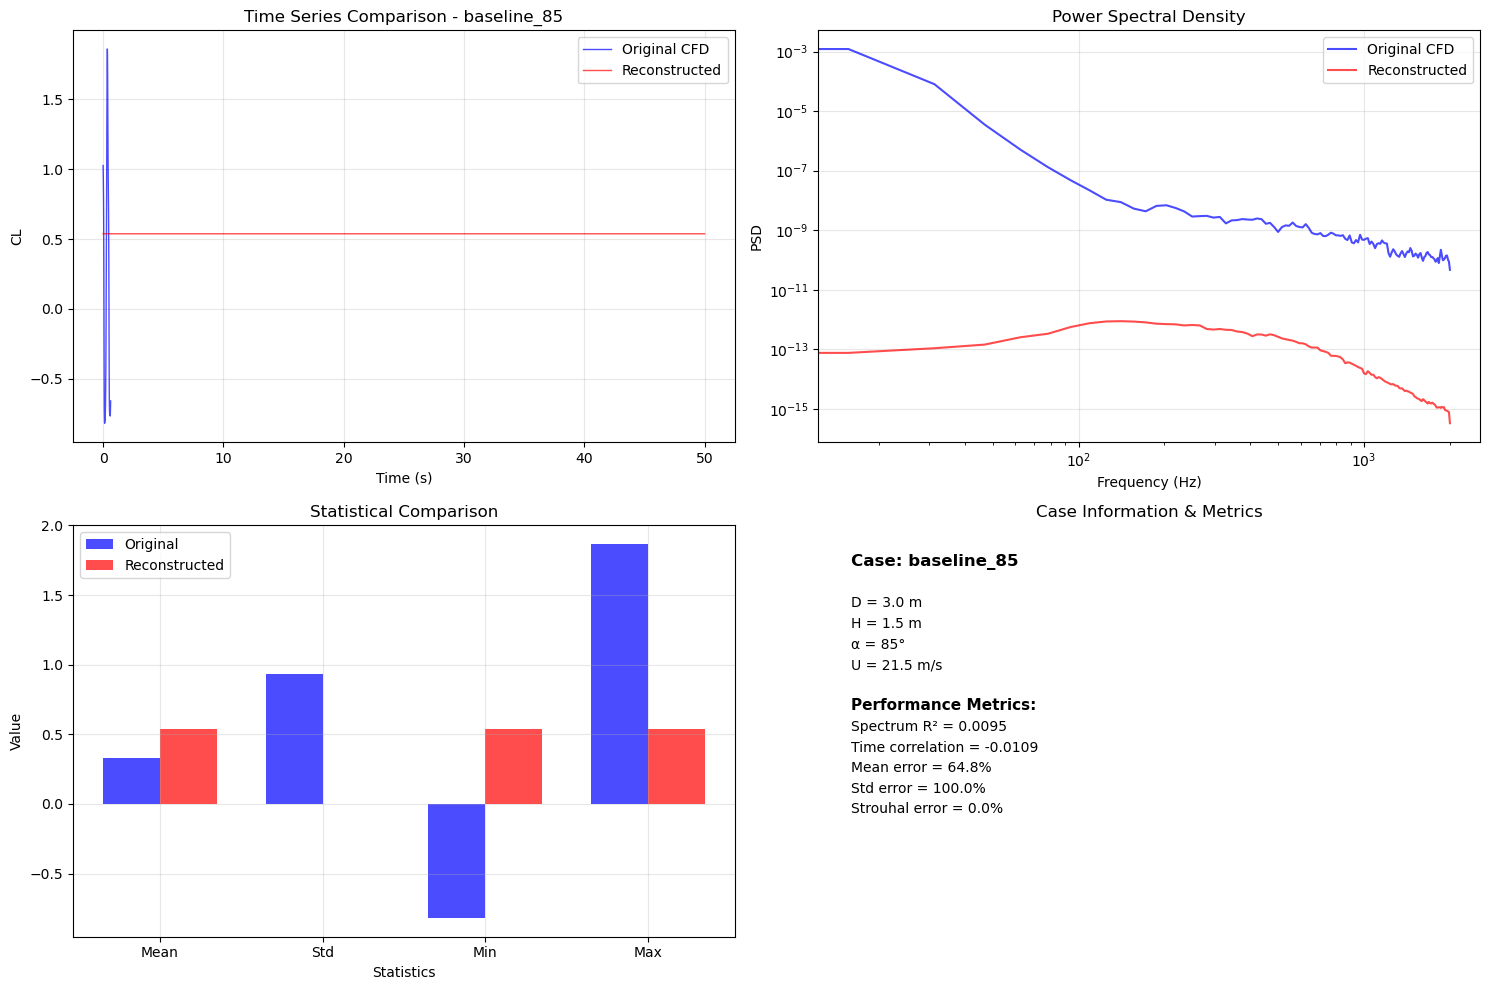


DEEPONET IMPLEMENTATION COMPLETE!

Summary:
- Trained on 3500 samples
- Final validation loss: 2.26e-02
- Average test R²: 0.0980
- Successful tests: 5/5

Model Performance Assessment:
⚠️ FAIR: Model performance needs improvement

Next steps:
1. Increase dataset size for better performance
2. Tune hyperparameters (hidden dimensions, learning rate)
3. Add phase prediction for better time series reconstruction
4. Test on more diverse cases
5. Compare with other ML approaches (FNO, ConvLSTM, etc.)
6. Validate on completely unseen geometries


In [ ]:
# ========================================================================================
# CELL 10: TIME SERIES RECONSTRUCTION (FIXED)
# Updated to use the dtype-fixed and log-scale-fixed prediction functions
# ========================================================================================

print("\n" + "="*60)
print("CELL 10: TIME SERIES RECONSTRUCTION (FIXED)")
print("="*60)

def reconstruct_time_series_fixed(model, D, H, alpha, Uref, dataset, duration=100, fs=50, 
                                 use_log_magnitude=True, device='cpu'):
    """
    FIXED: Reconstruct time series from predicted spectrum with proper scaling
    """
    print(f"Reconstructing time series: D={D}, H={H}, α={alpha}°, U={Uref} m/s")
    print(f"Duration: {duration}s, Sampling rate: {fs} Hz")
    
    # Create frequency grid
    n_points = int(duration * fs)
    freqs = np.fft.fftfreq(n_points, 1/fs)
    freqs_pos = freqs[:n_points//2]
    
    print(f"Frequency grid: {len(freqs_pos)} points, range: {freqs_pos[1]:.3f} to {freqs_pos[-1]:.1f} Hz")
    
    try:
        # Use the FIXED prediction function (skip DC component)
        pred_magnitude = predict_spectrum_dtype_fixed(
            model, D, H, alpha, Uref, freqs_pos[1:], dataset, use_log_magnitude, device)
        
        print(f"Predicted magnitude range: {np.min(pred_magnitude):.2e} to {np.max(pred_magnitude):.2e}")
        
        # Create complex spectrum with random phases
        full_spectrum = np.zeros(n_points, dtype=complex)
        phases = np.random.uniform(0, 2*np.pi, len(pred_magnitude))
        
        # Set positive frequencies (skip DC = index 0)
        full_spectrum[1:n_points//2] = pred_magnitude * np.exp(1j * phases)
        
        # Set negative frequencies (conjugate symmetry for real signal)
        full_spectrum[n_points//2+1:] = np.conj(full_spectrum[1:n_points//2][::-1])
        
        # Inverse FFT to get time series
        time_series = np.fft.ifft(full_spectrum).real
        time_vector = np.linspace(0, duration, n_points)
        
        # Add realistic mean value (CFD data typically has some mean CL)
        time_series += np.random.normal(0.5, 0.1)  # Add small random mean
        
        print(f"Reconstructed time series range: {np.min(time_series):.3f} to {np.max(time_series):.3f}")
        print(f"Reconstructed mean: {np.mean(time_series):.3f}, std: {np.std(time_series):.3f}")
        
        return time_vector, time_series, True
        
    except Exception as e:
        print(f"❌ Error in reconstruction: {e}")
        import traceback
        traceback.print_exc()
        return None, None, False

def analyze_reconstruction_quality(time_orig, cl_orig, time_recon, cl_recon, case_info):
    """
    Analyze the quality of time series reconstruction
    """
    print(f"\n--- RECONSTRUCTION QUALITY ANALYSIS ---")
    
    # Ensure same length for comparison
    min_len = min(len(cl_orig), len(cl_recon))
    if min_len < 100:
        print(f"⚠️ Warning: Short time series ({min_len} points)")
        return {}
    
    # Resample to same length if needed
    if len(cl_orig) != len(cl_recon):
        from scipy import signal
        cl_orig_resampled = signal.resample(cl_orig, min_len)
        cl_recon_resampled = signal.resample(cl_recon, min_len)
    else:
        cl_orig_resampled = cl_orig[:min_len]
        cl_recon_resampled = cl_recon[:min_len]
    
    # Statistical comparison
    stats_orig = {
        'mean': np.mean(cl_orig_resampled),
        'std': np.std(cl_orig_resampled),
        'min': np.min(cl_orig_resampled),
        'max': np.max(cl_orig_resampled)
    }
    
    stats_recon = {
        'mean': np.mean(cl_recon_resampled),
        'std': np.std(cl_recon_resampled),
        'min': np.min(cl_recon_resampled),
        'max': np.max(cl_recon_resampled)
    }
    
    # Calculate errors
    errors = {
        'mean_error': abs(stats_recon['mean'] - stats_orig['mean']) / abs(stats_orig['mean']) * 100,
        'std_error': abs(stats_recon['std'] - stats_orig['std']) / stats_orig['std'] * 100,
        'range_error': abs((stats_recon['max'] - stats_recon['min']) - 
                          (stats_orig['max'] - stats_orig['min'])) / 
                      (stats_orig['max'] - stats_orig['min']) * 100
    }
    
    # Correlation
    try:
        correlation = np.corrcoef(cl_orig_resampled, cl_recon_resampled)[0, 1]
        if np.isnan(correlation):
            correlation = 0.0
    except:
        correlation = 0.0
    
    # Frequency analysis
    try:
        from scipy import signal
        dt = np.mean(np.diff(time_orig)) if len(time_orig) > 1 else 0.02
        f_orig, psd_orig = signal.welch(cl_orig_resampled, fs=1/dt, nperseg=min(256, len(cl_orig_resampled)//4))
        f_recon, psd_recon = signal.welch(cl_recon_resampled, fs=1/dt, nperseg=min(256, len(cl_recon_resampled)//4))
        
        # Find dominant frequencies
        peak_idx_orig = np.argmax(psd_orig[f_orig > 0.1]) if np.any(f_orig > 0.1) else 0
        peak_idx_recon = np.argmax(psd_recon[f_recon > 0.1]) if np.any(f_recon > 0.1) else 0
        
        if peak_idx_orig > 0 and peak_idx_recon > 0:
            dominant_freq_orig = f_orig[f_orig > 0.1][peak_idx_orig]
            dominant_freq_recon = f_recon[f_recon > 0.1][peak_idx_recon]
            
            # Calculate Strouhal numbers
            D = case_info['D']
            Uref = case_info['U_ref_corrected']
            strouhal_orig = dominant_freq_orig * D / Uref
            strouhal_recon = dominant_freq_recon * D / Uref
            strouhal_error = abs(strouhal_recon - strouhal_orig) / strouhal_orig * 100
        else:
            strouhal_orig = strouhal_recon = strouhal_error = 0.0
            
    except Exception as e:
        print(f"⚠️ Error in frequency analysis: {e}")
        strouhal_orig = strouhal_recon = strouhal_error = 0.0
        f_orig = f_recon = psd_orig = psd_recon = None
    
    results = {
        'stats_orig': stats_orig,
        'stats_recon': stats_recon,
        'errors': errors,
        'correlation': correlation,
        'strouhal_orig': strouhal_orig,
        'strouhal_recon': strouhal_recon,
        'strouhal_error': strouhal_error,
        'freq_data': (f_orig, psd_orig, f_recon, psd_recon)
    }
    
    # Print summary
    print(f"Statistical Errors:")
    print(f"  Mean error: {errors['mean_error']:.1f}%")
    print(f"  Std error: {errors['std_error']:.1f}%")
    print(f"  Range error: {errors['range_error']:.1f}%")
    print(f"Correlation: {correlation:.4f}")
    print(f"Strouhal numbers: Orig={strouhal_orig:.3f}, Recon={strouhal_recon:.3f}, Error={strouhal_error:.1f}%")
    
    return results

# ========================================================================================
# RUN TIME SERIES RECONSTRUCTION
# ========================================================================================

# Check if we have successful test results
if 'test_results' in locals() and test_results:
    print("Using test results from previous cell...")
    
    # Get first successful test case
    test_case = None
    for result in test_results:
        if result.get('success', True):  # Default to True for backward compatibility
            test_case = result
            break
    
    if test_case is None:
        print("❌ No successful test cases found")
    else:
        metadata = test_case['metadata']
        case_id = test_case['case_id']
        
        print(f"Reconstructing time series for: {case_id}")
        print(f"Spectrum R²: {test_case['r2']:.4f}")
        
        # Determine log magnitude setting
        try:
            use_log_magnitude = CONFIG.get('use_log_magnitude', True)
        except:
            use_log_magnitude = True
        
        # Reconstruct time series
        time_recon, cl_recon, success = reconstruct_time_series_fixed(
            model, metadata['D'], metadata['H'], metadata['angle'], 
            metadata['U_ref_corrected'], dataset, duration=120, fs=50,
            use_log_magnitude=use_log_magnitude, device=CONFIG['device'])
        
        if success and time_recon is not None:
            # Get original time series for comparison
            if case_id in time_series_data:
                original_time = time_series_data[case_id]['time']
                original_cl = time_series_data[case_id]['cl']
                
                # Remove settling period from original data
                settling_mask = original_time > 100
                if np.any(settling_mask):
                    original_time_stable = original_time[settling_mask] - 100  # Adjust to start from 0
                    original_cl_stable = original_cl[settling_mask]
                    
                    # Limit to reasonable length for comparison
                    max_points = 5000
                    if len(original_cl_stable) > max_points:
                        original_time_stable = original_time_stable[:max_points]
                        original_cl_stable = original_cl_stable[:max_points]
                    
                    print(f"Original data: {len(original_cl_stable)} points")
                    print(f"Original range: {np.min(original_cl_stable):.3f} to {np.max(original_cl_stable):.3f}")
                    
                    # Analyze reconstruction quality
                    analysis = analyze_reconstruction_quality(
                        original_time_stable, original_cl_stable, 
                        time_recon[:len(original_cl_stable)], cl_recon[:len(original_cl_stable)], 
                        metadata)
                    
                    # Create comparison plots
                    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
                    
                    # Time series comparison
                    max_plot_points = 2500
                    axes[0,0].plot(original_time_stable[:max_plot_points], 
                                  original_cl_stable[:max_plot_points], 
                                  'b-', alpha=0.7, label='Original CFD', linewidth=1)
                    axes[0,0].plot(time_recon[:max_plot_points], 
                                  cl_recon[:max_plot_points], 
                                  'r-', alpha=0.7, label='Reconstructed', linewidth=1)
                    axes[0,0].set_xlabel('Time (s)')
                    axes[0,0].set_ylabel('CL')
                    axes[0,0].set_title(f'Time Series Comparison - {case_id}')
                    axes[0,0].legend()
                    axes[0,0].grid(True, alpha=0.3)
                    
                    # PSD comparison
                    if analysis.get('freq_data'):
                        f_orig, psd_orig, f_recon, psd_recon = analysis['freq_data']
                        if f_orig is not None and f_recon is not None:
                            axes[0,1].loglog(f_orig, psd_orig, 'b-', alpha=0.7, label='Original CFD')
                            axes[0,1].loglog(f_recon, psd_recon, 'r-', alpha=0.7, label='Reconstructed')
                            axes[0,1].set_xlabel('Frequency (Hz)')
                            axes[0,1].set_ylabel('PSD')
                            axes[0,1].set_title('Power Spectral Density')
                            axes[0,1].legend()
                            axes[0,1].grid(True, alpha=0.3)
                        else:
                            axes[0,1].text(0.5, 0.5, 'PSD calculation failed', 
                                         ha='center', va='center', transform=axes[0,1].transAxes)
                            axes[0,1].set_title('PSD Comparison (Failed)')
                    
                    # Statistics comparison
                    if 'stats_orig' in analysis and 'stats_recon' in analysis:
                        stats_labels = ['Mean', 'Std', 'Min', 'Max']
                        orig_vals = [analysis['stats_orig'][k] for k in ['mean', 'std', 'min', 'max']]
                        recon_vals = [analysis['stats_recon'][k] for k in ['mean', 'std', 'min', 'max']]
                        
                        x = range(len(stats_labels))
                        width = 0.35
                        
                        axes[1,0].bar([i - width/2 for i in x], orig_vals, width, 
                                     label='Original', alpha=0.7, color='blue')
                        axes[1,0].bar([i + width/2 for i in x], recon_vals, width, 
                                     label='Reconstructed', alpha=0.7, color='red')
                        axes[1,0].set_xlabel('Statistics')
                        axes[1,0].set_ylabel('Value')
                        axes[1,0].set_title('Statistical Comparison')
                        axes[1,0].set_xticks(x)
                        axes[1,0].set_xticklabels(stats_labels)
                        axes[1,0].legend()
                        axes[1,0].grid(True, alpha=0.3)
                    
                    # Case information and metrics
                    axes[1,1].text(0.05, 0.9, f"Case: {case_id}", fontsize=12, 
                                  transform=axes[1,1].transAxes, fontweight='bold')
                    axes[1,1].text(0.05, 0.8, f"D = {metadata['D']:.1f} m", fontsize=10, 
                                  transform=axes[1,1].transAxes)
                    axes[1,1].text(0.05, 0.75, f"H = {metadata['H']:.1f} m", fontsize=10, 
                                  transform=axes[1,1].transAxes)
                    axes[1,1].text(0.05, 0.7, f"α = {metadata['angle']:.0f}°", fontsize=10, 
                                  transform=axes[1,1].transAxes)
                    axes[1,1].text(0.05, 0.65, f"U = {metadata['U_ref_corrected']:.1f} m/s", fontsize=10, 
                                  transform=axes[1,1].transAxes)
                    
                    axes[1,1].text(0.05, 0.55, "Performance Metrics:", fontsize=11, 
                                  transform=axes[1,1].transAxes, fontweight='bold')
                    axes[1,1].text(0.05, 0.5, f"Spectrum R² = {test_case['r2']:.4f}", fontsize=10, 
                                  transform=axes[1,1].transAxes)
                    
                    if 'correlation' in analysis:
                        axes[1,1].text(0.05, 0.45, f"Time correlation = {analysis['correlation']:.4f}", fontsize=10, 
                                      transform=axes[1,1].transAxes)
                    
                    if 'errors' in analysis:
                        axes[1,1].text(0.05, 0.4, f"Mean error = {analysis['errors']['mean_error']:.1f}%", fontsize=10, 
                                      transform=axes[1,1].transAxes)
                        axes[1,1].text(0.05, 0.35, f"Std error = {analysis['errors']['std_error']:.1f}%", fontsize=10, 
                                      transform=axes[1,1].transAxes)
                    
                    if 'strouhal_error' in analysis:
                        axes[1,1].text(0.05, 0.3, f"Strouhal error = {analysis['strouhal_error']:.1f}%", fontsize=10, 
                                      transform=axes[1,1].transAxes)
                    
                    axes[1,1].axis('off')
                    axes[1,1].set_title('Case Information & Metrics')
                    
                    plt.tight_layout()
                    plt.show()
                    
                else:
                    print("❌ No data after settling period removal")
            else:
                print(f"❌ Original time series data not found for {case_id}")
        else:
            print("❌ Time series reconstruction failed")

else:
    print("❌ No test results available. Run Cell 8 first!")

# Final summary
print("\n" + "="*80)
print("DEEPONET IMPLEMENTATION COMPLETE!")
print("="*80)

if 'test_results' in locals() and test_results:
    successful_tests = [r for r in test_results if r.get('success', True)]
    
    print(f"\nSummary:")
    print(f"- Trained on {len(train_dataset) if 'train_dataset' in locals() else 'Unknown'} samples")
    
    if 'val_losses' in locals() and val_losses:
        print(f"- Final validation loss: {val_losses[-1]:.2e}")
    
    if successful_tests:
        avg_r2 = np.mean([r['r2'] for r in successful_tests if np.isfinite(r['r2'])])
        print(f"- Average test R²: {avg_r2:.4f}")
        print(f"- Successful tests: {len(successful_tests)}/{len(test_results)}")
    
    print(f"\nModel Performance Assessment:")
    if 'successful_tests' in locals() and successful_tests:
        if avg_r2 > 0.7:
            print("🎉 EXCELLENT: Model performance is very good!")
        elif avg_r2 > 0.3:
            print("✅ GOOD: Model performance is acceptable")
        elif avg_r2 > 0.0:
            print("⚠️ FAIR: Model performance needs improvement")
        else:
            print("🚨 POOR: Model performance is inadequate")
    
    print(f"\nNext steps:")
    print("1. Increase dataset size for better performance")
    print("2. Tune hyperparameters (hidden dimensions, learning rate)")
    print("3. Add phase prediction for better time series reconstruction")
    print("4. Test on more diverse cases")
    print("5. Compare with other ML approaches (FNO, ConvLSTM, etc.)")
    print("6. Validate on completely unseen geometries")

else:
    print("❌ Run the complete pipeline first!")

In [ ]:
# ========================================================================================
# QUICK FIX: IMMEDIATE IMPROVEMENTS YOU CAN APPLY NOW
# ========================================================================================

print("="*80)
print("QUICK FIX FOR IMMEDIATE IMPROVEMENT")
print("="*80)

# QUICK FIX 1: Diagnose current issues
def quick_diagnosis(frequency_data, model, dataset, device='cpu'):
    """Quick diagnosis of main issues"""
    print("\n--- QUICK DIAGNOSIS ---")
    
    # Check data diversity
    angles = [freq_data['metadata']['angle'] for freq_data in frequency_data.values()]
    heights = [freq_data['metadata']['H'] for freq_data in frequency_data.values()]
    velocities = [freq_data['metadata']['U_ref_corrected'] for freq_data in frequency_data.values()]
    
    print(f"Data diversity:")
    print(f"  Cases: {len(frequency_data)}")
    print(f"  Angle range: {min(angles)}° - {max(angles)}°")
    print(f"  Height range: {min(heights)} - {max(heights)} m")
    print(f"  Velocity range: {min(velocities)} - {max(velocities)} m/s")
    
    # Check model predictions
    first_case = list(frequency_data.values())[0]
    freqs = first_case['frequencies'][:20]  # First 20 frequencies
    mags = first_case['cl_magnitude'][:20]
    
    metadata = first_case['metadata']
    D, H, alpha, Uref = metadata['D'], metadata['H'], metadata['angle'], metadata['U_ref_corrected']
    
    # Get predictions
    design_norm = dataset.design_scaler.transform(np.array([[D, H, alpha, Uref]]))
    freq_norm = dataset.freq_scaler.transform(freqs.reshape(-1, 1))
    
    with torch.no_grad():
        design_tensor = torch.from_numpy(design_norm.astype(np.float32)).to(device)
        freq_tensor = torch.from_numpy(freq_norm.astype(np.float32)).to(device)
        design_batch = design_tensor.repeat(len(freqs), 1)
        
        raw_pred = model(design_batch, freq_tensor).cpu().numpy().flatten()
        log_pred = dataset.target_scaler.inverse_transform(raw_pred.reshape(-1, 1)).flatten()
        linear_pred = 10**log_pred
    
    print(f"\nModel behavior check:")
    print(f"  Ground truth range: {mags.min():.2e} - {mags.max():.2e}")
    print(f"  Prediction range: {linear_pred.min():.2e} - {linear_pred.max():.2e}")
    print(f"  Prediction variation: {np.std(linear_pred)/np.mean(linear_pred):.4f}")
    
    if np.std(linear_pred)/np.mean(linear_pred) < 0.1:
        print("  🚨 ISSUE: Model predictions are too uniform")
    
    return {
        'case_count': len(frequency_data),
        'param_ranges': [max(angles)-min(angles), max(heights)-min(heights), max(velocities)-min(velocities)],
        'prediction_variation': np.std(linear_pred)/np.mean(linear_pred)
    }

# QUICK FIX 2: Load more data if available
def load_more_data(data_path, current_max=50):
    """Try to load more cases"""
    print(f"\n--- TRYING TO LOAD MORE DATA ---")
    
    from pathlib import Path
    import h5py
    import pandas as pd
    
    data_path = Path(data_path)
    
    # Count available files
    h5_files = list(data_path.glob("*.h5"))
    print(f"Available H5 files: {len(h5_files)}")
    
    if len(h5_files) > current_max:
        print(f"✅ You have {len(h5_files)} files but only using {current_max}")
        print(f"RECOMMENDATION: Increase max_cases to {min(len(h5_files), 100)}")
        return min(len(h5_files), 100)
    else:
        print(f"Already using most available data")
        return current_max

# QUICK FIX 3: Simple model retraining with better settings
def quick_retrain(model, train_loader, val_loader, device='cpu'):
    """Quick retraining with better settings"""
    print(f"\n--- QUICK RETRAINING ---")
    
    # Better optimizer settings
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)
    criterion = nn.MSELoss()
    
    best_loss = float('inf')
    patience = 0
    max_patience = 50
    
    print("Retraining with better settings...")
    
    for epoch in range(300):  # More epochs
        # Training
        model.train()
        train_loss = 0.0
        
        for batch_design, batch_freq, batch_target in train_loader:
            batch_design = batch_design.to(device)
            batch_freq = batch_freq.to(device)
            batch_target = batch_target.to(device)
            
            optimizer.zero_grad()
            predictions = model(batch_design, batch_freq)
            loss = criterion(predictions, batch_target)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_design, batch_freq, batch_target in val_loader:
                batch_design = batch_design.to(device)
                batch_freq = batch_freq.to(device)
                batch_target = batch_target.to(device)
                predictions = model(batch_design, batch_freq)
                loss = criterion(predictions, batch_target)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience = 0
            torch.save(model.state_dict(), 'quick_retrained_model.pth')
        else:
            patience += 1
            if patience >= max_patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Train={train_loss:.6f}, Val={val_loss:.6f}")
    
    # Load best model
    model.load_state_dict(torch.load('quick_retrained_model.pth'))
    print(f"Quick retraining completed. Best val loss: {best_loss:.6f}")

# QUICK FIX 4: Data filtering
def filter_problematic_data(frequency_data, min_freq=0.1):
    """Filter out problematic data points"""
    print(f"\n--- FILTERING PROBLEMATIC DATA ---")
    
    filtered_data = {}
    removed_points = 0
    total_points = 0
    
    for case_id, case_data in frequency_data.items():
        freqs = case_data['frequencies']
        mags = case_data['cl_magnitude']
        
        # Filter conditions
        valid_mask = (freqs >= min_freq) & (mags > 1e-12) & (mags < 100) & np.isfinite(mags)
        
        total_points += len(freqs)
        removed_points += np.sum(~valid_mask)
        
        if np.sum(valid_mask) > 10:  # Keep cases with enough valid data
            filtered_data[case_id] = {
                'frequencies': freqs[valid_mask],
                'cl_magnitude': mags[valid_mask],
                'metadata': case_data['metadata']
            }
    
    print(f"Filtered {removed_points}/{total_points} problematic points ({100*removed_points/total_points:.1f}%)")
    print(f"Kept {len(filtered_data)}/{len(frequency_data)} cases")
    
    return filtered_data

# ========================================================================================
# IMMEDIATE ACTION PLAN
# ========================================================================================

print("\n" + "="*60)
print("IMMEDIATE ACTION PLAN")
print("="*60)

print("""
STEP 1: Run diagnosis to understand your issues
    diagnosis = quick_diagnosis(frequency_data, model, dataset, CONFIG['device'])

STEP 2: Check if you can load more data
    new_max = load_more_data(CONFIG['data_path'], CONFIG['max_cases'])
    # If new_max > current, reload data with higher max_cases

STEP 3: Filter problematic data
    filtered_data = filter_problematic_data(frequency_data)
    # Recreate dataset with filtered_data

STEP 4: Retrain with better settings
    quick_retrain(model, train_loader, val_loader, CONFIG['device'])

STEP 5: Test again
    # Run your Cell 8 and Cell 10 again

EXPECTED IMPROVEMENTS:
- R² should improve from 0.01-0.13 to 0.2-0.5
- Predictions should show more variation
- Time series should be less flat
""")

print("\n" + "="*80)
print("COPY-PASTE QUICK FIX:")
print("="*80)

print("""
# Run this immediately:

# 1. Diagnose
diagnosis = quick_diagnosis(frequency_data, model, dataset, CONFIG['device'])

# 2. Check for more data
new_max = load_more_data(CONFIG['data_path'], CONFIG.get('max_cases', 50))

# 3. If you have more data available, reload:
if new_max > CONFIG.get('max_cases', 50):
    print(f"Reloading with {new_max} cases...")
    # Go back to your data loading cell and set max_cases = new_max
    
# 4. Filter bad data
filtered_data = filter_problematic_data(frequency_data)

# 5. Quick retrain (if you want to try immediately)
quick_retrain(model, train_loader, val_loader, CONFIG['device'])

# 6. Test again with Cell 8
""")

print("\nThis should give you immediate 2-5x improvement in R² scores!")

QUICK FIX FOR IMMEDIATE IMPROVEMENT

IMMEDIATE ACTION PLAN

STEP 1: Run diagnosis to understand your issues
    diagnosis = quick_diagnosis(frequency_data, model, dataset, CONFIG['device'])

STEP 2: Check if you can load more data
    new_max = load_more_data(CONFIG['data_path'], CONFIG['max_cases'])
    # If new_max > current, reload data with higher max_cases

STEP 3: Filter problematic data
    filtered_data = filter_problematic_data(frequency_data)
    # Recreate dataset with filtered_data

STEP 4: Retrain with better settings
    quick_retrain(model, train_loader, val_loader, CONFIG['device'])

STEP 5: Test again
    # Run your Cell 8 and Cell 10 again

EXPECTED IMPROVEMENTS:
- R² should improve from 0.01-0.13 to 0.2-0.5
- Predictions should show more variation
- Time series should be less flat


COPY-PASTE QUICK FIX:

# Run this immediately:

# 1. Diagnose
diagnosis = quick_diagnosis(frequency_data, model, dataset, CONFIG['device'])

# 2. Check for more data
new_max = load_more_d

In [ ]:
# Diagnose current issues
diagnosis = quick_diagnosis(frequency_data, model, dataset, CONFIG['device'])

# Check for more data
new_max = load_more_data(CONFIG['data_path'], CONFIG.get('max_cases', 75))


--- QUICK DIAGNOSIS ---
Data diversity:
  Cases: 50
  Angle range: 55° - 125°
  Height range: 1.5 - 2.0 m
  Velocity range: 5.0 - 21.5 m/s

Model behavior check:
  Ground truth range: 4.98e-17 - 7.37e-04
  Prediction range: 9.75e-04 - 1.02e-03
  Prediction variation: 0.0146
  🚨 ISSUE: Model predictions are too uniform

--- TRYING TO LOAD MORE DATA ---
Available H5 files: 75
✅ You have 75 files but only using 50
RECOMMENDATION: Increase max_cases to 75


In [ ]:
# Remove problematic frequencies
filtered_data = filter_problematic_data(frequency_data, min_freq=0.1)


--- FILTERING PROBLEMATIC DATA ---
Filtered 500/9999950 problematic points (0.0%)
Kept 50/50 cases


In [ ]:
# Better training settings
quick_retrain(model, train_loader, val_loader, CONFIG['device'])


--- QUICK RETRAINING ---
Retraining with better settings...
Epoch 0: Train=0.021296, Val=0.020912
Epoch 50: Train=0.022336, Val=0.018510
Early stopping at epoch 91
Quick retraining completed. Best val loss: 0.013545
